# Order Parameters

In this notebook, we analyze the order parameters of the cells.
We will use the information available in the folder `dat_order_parameters` which has the information of the global order parameters during the simulations at each time step and for each seed.

We define different order parameters in order to visualize how is the structure:

- Nematic Order ($Q$): The well-known nematic order calculated using the number of elongated cells as follows:

$$ Q = \frac{1}{N_e} \sqrt{\left(\sum_{i=1}^{N_e} \sin (2\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (2\varphi_i)\right)^2}$$

- Polar Order ($P$): The well-known polar order calculated using the number of elongated cells as follows:

$$ P = \frac{1}{N_e} \sqrt{\left(\sum_{i=1}^{N_e} \sin (\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (\varphi_i)\right)^2}$$

- Nematic Order 2 ($\hat{Q}$): The same nematic parameter as before but dividing by all the cells (including the rounds):

$$ \hat{Q} = \frac{1}{N} \sqrt{\left(\sum_{i=1}^{N_e} \sin (2\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (2\varphi_i)\right)^2}$$

- Polar Order 2 ($\hat{P}$): The same polar parameter as before but dividing by all the cells (including the rounds):

$$ \hat{P} = \frac{1}{N} \sqrt{\left(\sum_{i=1}^{N_e} \sin (\varphi_i)\right)^2+\left(\sum_{i=1}^{N_e} \cos (\varphi_i)\right)^2}$$

## Order parameters evolution

First of all, let's calculate how the order parameters change in time arriving to an steady state for a given density.

In [1]:
# import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

We define some relevant parameters that remains constant during the simulations.

In [2]:
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each variable (nematic order 1 and 2, polar order 1 and 2) for each step.

In [3]:
def calculate_order_parameters_vs_time(num_cells, dens, max_step, step, rng_seed):
    """
    Calculates polar and nematic order parameters as a function of time
    for a given density and list of seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the polar and nematic order parameters at 
        different time steps for each seed.
    """

    # Initialize the lists for order parameters 1
    nematic_order = []
    polar_order = []
    # Initialize the lists for order parameters 2
    nematic_2_order = []
    polar_2_order = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        nematic_step = np.array([])
        polar_step = np.array([])
        # and for op 2
        nematic_2_step = np.array([])
        polar_2_step = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"data/{num_cells_folder}/{dens_folder}/dat_order_parameters/op_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            nematic_seed = df_tic["nematic"].mean()
            polar_seed = df_tic["polar"].mean()
            # and for op 2
            nematic_2_seed = df_tic["nematic_2"].mean()
            polar_2_seed = df_tic["polar_2"].mean()
            # Add them to the steps's array
            nematic_step = np.append(nematic_step, nematic_seed)
            polar_step = np.append(polar_step, polar_seed)
            # and for op 2
            nematic_2_step = np.append(nematic_2_step, nematic_2_seed)
            polar_2_step = np.append(polar_2_step, polar_2_seed)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        nematic_mean = np.mean(nematic_step)
        polar_mean = np.mean(polar_step)
        # and for op 2
        nematic_2_mean = np.mean(nematic_2_step)
        polar_2_mean = np.mean(polar_2_step)
        # Add them to the global list
        nematic_order.append(nematic_mean)
        polar_order.append(polar_mean)
        # and for op 2
        nematic_2_order.append(nematic_2_mean)
        polar_2_order.append(polar_2_mean)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "nematic": nematic_order,
        "polar": polar_order,
        "nematic_2": nematic_2_order,
        "polar_2": polar_2_order,
    })

    return df

We also create a function to plot the order parameters evolution.

In [4]:
def plot_order_parameters_evolution(df, dens, num_cells):
    """
    Plots the temporal evolution of polar and nematic order parameters
    for a given cell density.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing polar and nematic order parameters as a 
        function of time for multiple seeds.
    dens : float
        Cell density used in the simulation.
    num_cells : int
        Number of cells in the simulation.
    """

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # First plot
    axs[0].plot(df["step"], df["nematic"], label="Nematic order (Q)", color="blue")
    axs[0].plot(df["step"], df["polar"], label="Polar order (Q)", color="green")
    axs[0].set_title("Order parameters 1")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Order parameter")
    axs[0].legend()

    # Second plot
    axs[1].plot(df["step"], df["nematic_2"], label=r"Nematic order ($\hat{Q}$)", color="blue")
    axs[1].plot(df["step"], df["polar_2"], label=r"Polar order ($\hat{P}$)", color="green")
    axs[1].set_title("Order parameters 2")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Order parameter")
    axs[1].legend()

    fig.suptitle(f"Order Parameters vs Time (N={num_cells}, density = {dens})")
    plt.tight_layout()

    # Guardar el gráfico
    num_cells_folder = f"N={num_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/order_parameters/op_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"op_evolution_N={num_cells}_density_{dens:.2f}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

### Particular density and number of cells

In the case we want to see only one particular density and number of cells, continue as follows. We get the dataframe with the function and then plot it.

Last step =  50000  for density =  0.5


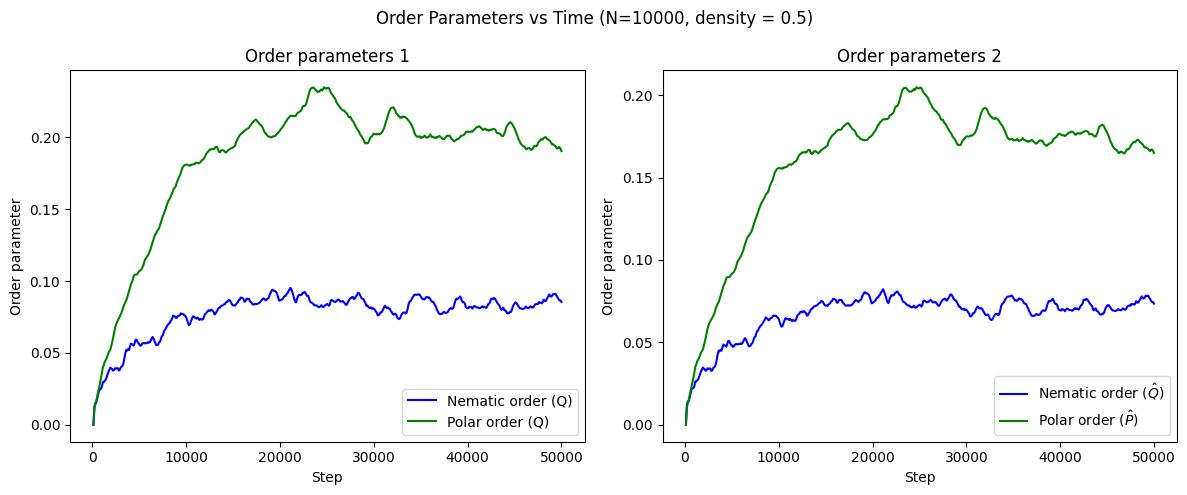

In [5]:
dens_input = input("Enter density (for example 0.50): ")
dens_nc = input("Enter number of cells (for example 10000): ")
try:
    density = float(dens_input)
    nc = int(dens_nc)
except ValueError:
    print("Error")
    exit()
df = calculate_order_parameters_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
#df.to_csv("{density_folder}/op_vs_time.csv", index=False)
plot_order_parameters_evolution(df, dens=density, num_cells=nc)

### N=10_000

We can see how is the order parameters evolution for each cell density in the case of N=10_000:

Last step =  50000  for density =  0.5


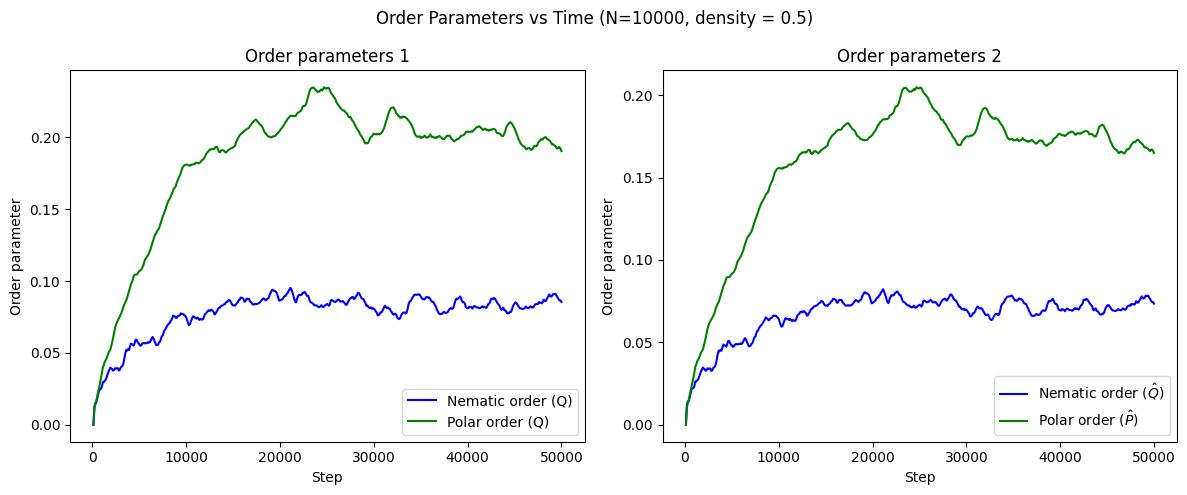

Last step =  50000  for density =  0.6


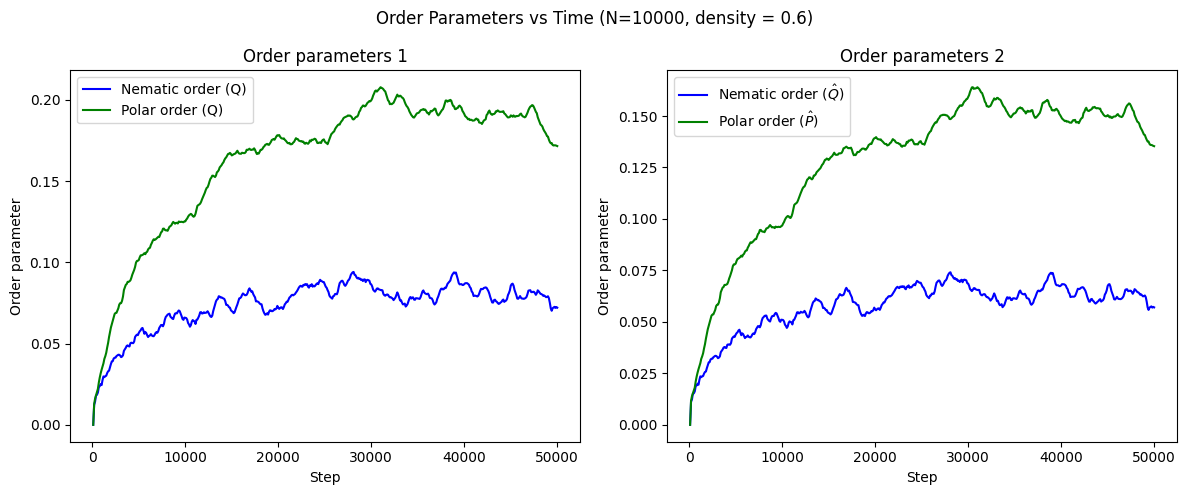

Last step =  50000  for density =  0.7


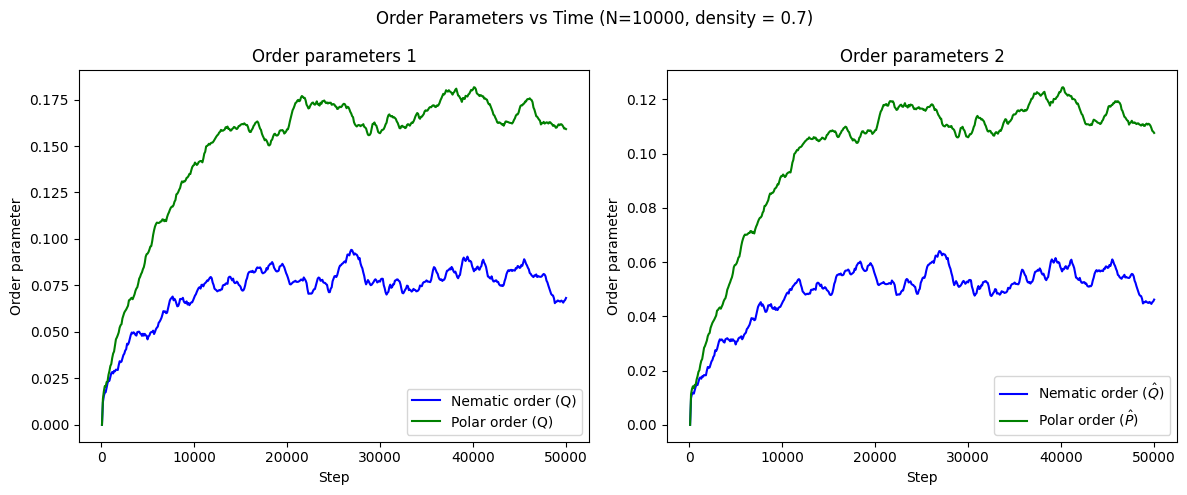

Last step =  50000  for density =  0.8


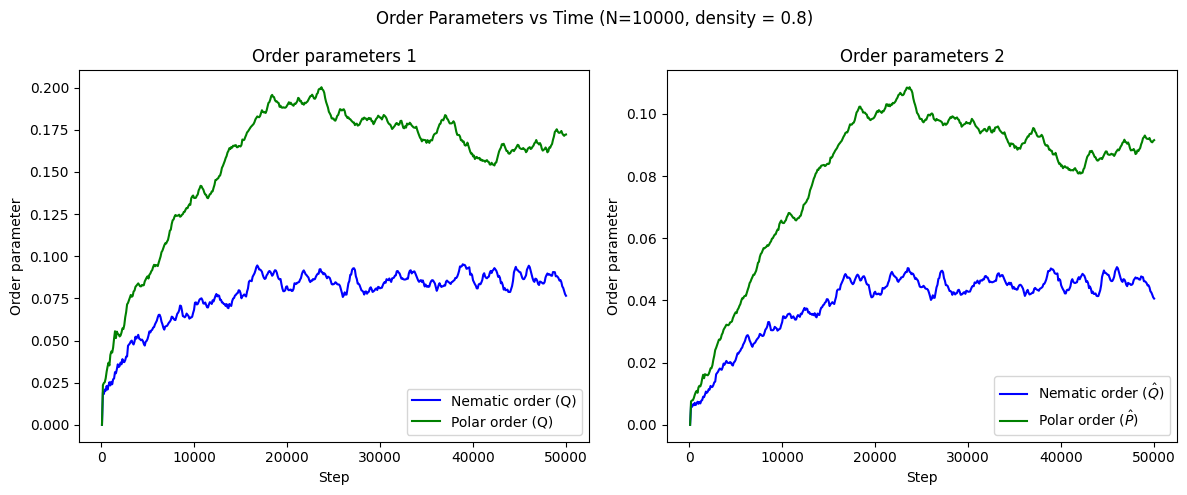

Last step =  48300  for density =  0.85


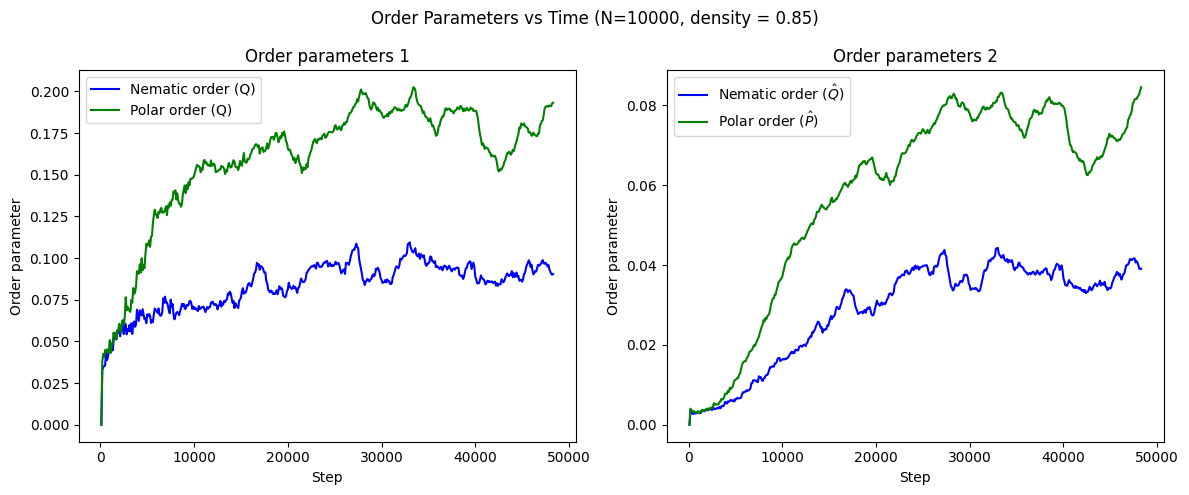

Last step =  10000  for density =  0.9


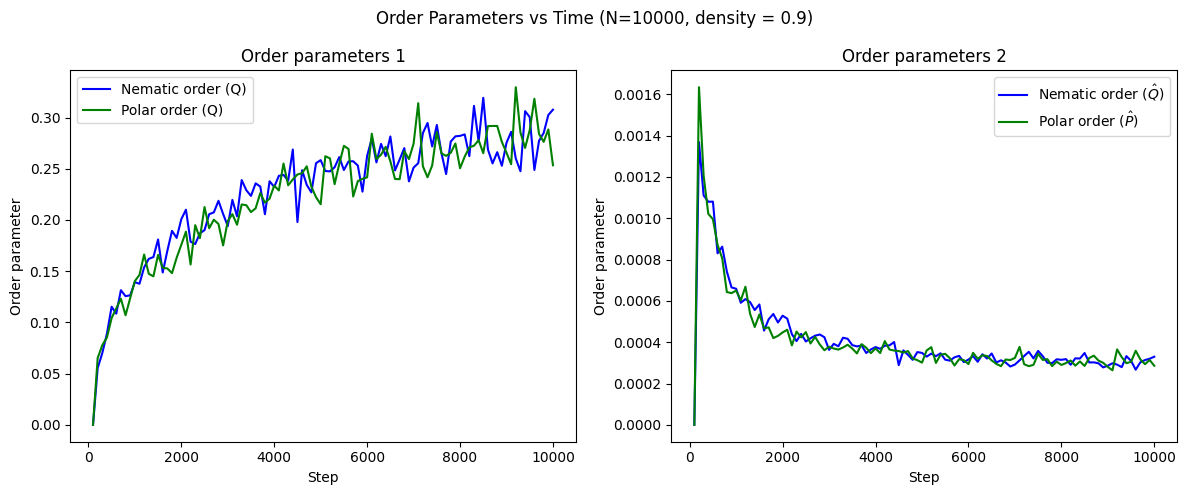

In [6]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
# Create a dict to save all the dataframes
dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_order_parameters_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/op_vs_time_density_{density:.2f}.csv", index=False)
    # Add it to the dict
    dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_order_parameters_evolution(df, dens=density, num_cells=number_of_cells)

### Steady State

Now we can plot how the final order parameters change with the density.

First we create a function to calculate the order parameters of the last step, saving the mean and the standard deviation.

In [7]:
def calculate_final_order_parameter(num_cells, max_step, dens, step, rng_seed):
    """
    Calculates the final polar and nematic order parameters at the last 
    time step (`max_step`) for a given density, averaging over multiple seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    max_step : int
        Final time step to analyze.
    dens : float
        Cell density used in the simulation.
    step : int
        Time step interval between saved data files.
    rng_seed : list of int
        List of random seeds corresponding to different simulation runs.

    Returns
    -------
    dict
        Dictionary with the mean and standard deviation of the polar and 
        nematic order parameters at the final time step.
    """
    # Name of the density folder to read the data
    dens_folder = f"{dens:.2f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    # Define a boolean to stop where there are no more data
    stop = False
    # Check for which was the last step
    for tic in range(100, max_step, step):
        for seed in rng_seed:
            dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_order_parameters/op_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={tic:05}.dat"
            if not os.path.exists(dat_actual):
                stop = True
                break
        if stop is True:
            last_step = tic - step
            break
    else:
        # if the for does not break, last step is the max
        last_step = max_step
    
    print("Last step = ", last_step, " for density = ", dens)
    
    # Initialize the lists for order parameters 1
    nematic_order = []
    polar_order = []
    # and for op 2
    nematic_2_order = []
    polar_2_order = []   
    # For each seed, we read de corresponding file 
    for seed in rng_seed:
        dat_actual = f"data/{num_cells_folder}/{dens_folder}/dat_order_parameters/op_culture_initial_number_of_cells={num_cells}_density={dens}_force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_rng_seed={seed}_step={last_step:05}.dat"

        if not os.path.exists(dat_actual):
            print(f"File not found: {dat_actual}")
            continue
        
        df_tic = pd.read_csv(dat_actual)
        # Take parameters of this particular seed
        nematic_mean = df_tic["nematic"].mean()
        polar_mean = df_tic["polar"].mean()
        # and for op 2
        nematic_2_mean = df_tic["nematic_2"].mean()
        polar_2_mean = df_tic["polar_2"].mean()

        # And add them to the list
        nematic_order.append(nematic_mean)
        polar_order.append(polar_mean)
        # also for op 2
        nematic_2_order.append(nematic_2_mean)
        polar_2_order.append(polar_2_mean)

    # return a dataframe with the mean and std for every op
    return {
        "mean": {
            "nematic_order": np.mean(nematic_order),
            "polar_order": np.mean(polar_order),
            "nematic_order_2": np.mean(nematic_2_order),
            "polar_order_2": np.mean(polar_2_order),
        },
        "std": {
            "nematic_order": np.std(nematic_order),
            "polar_order": np.std(polar_order),
            "nematic_order_2": np.std(nematic_2_order),
            "polar_order_2": np.std(polar_2_order),
        }
    }

Now we use this function to plot the steady states. We will need to create 2 DataFrames with the information of the mean and standard deviation for every density and give them to the plot function.

In [8]:
def plot_mean_and_variance_steady_states(df_mean, df_std, error_bars, var_names, labels, output_path, title):
    """
    Plots the mean and variance of each order parameter in the steady state.

    Parameters
    ----------
    df_mean : pandas.DataFrame
        DataFrame with mean values.
    df_std : pandas.DataFrame
        DataFrame with std values.
    error_bars : pandas.DataFrame
        DataFrame with standard error of the mean.
    var_names : list
        List of 2 labels for the legend.
    labels : list
        List of 2 labels for the legend.
    output_path: str
        Path to save the figure
    title: str
        Title of the whole figure
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    color1, color2 = "blue", "green"
    
    # First plot: mean with error bars
    axes[0].errorbar(df_mean["density"], df_mean[var_names[0]], 
                 yerr=error_bars[var_names[0] + "_std"], fmt='o-', color=color1, label=labels[0])
    axes[0].errorbar(df_mean["density"], df_mean[var_names[1]], 
                 yerr=error_bars[var_names[1] + "_std"], fmt='o-', color=color2, label=labels[1])
    axes[0].set_xlabel("Density ρ")
    axes[0].set_ylabel("Order parameter (mean)")
    axes[0].set_title("Mean ± Std Error")
    axes[0].legend()

    # Second plot: variance
    axes[1].plot(df_mean["density"], df_std[var_names[0] + "_std"]**2, marker='o', linestyle='--', color=color1, label=f"Var({labels[0]})")
    axes[1].plot(df_mean["density"], df_std[var_names[1] + "_std"]**2, marker='o', linestyle='--', color=color2, label=f"Var({labels[1]})")
    axes[1].set_xlabel("Density ρ")
    axes[1].set_ylabel("Variance")
    axes[1].set_title("Variance")
    axes[1].legend()

    fig.suptitle(title)
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

### N=10_000

Let's see the steady state of every density and N=10_000.

Last step =  50000  for density =  0.5
Last step =  50000  for density =  0.6
Last step =  50000  for density =  0.7
Last step =  50000  for density =  0.8
Last step =  48300  for density =  0.85
Last step =  10000  for density =  0.9


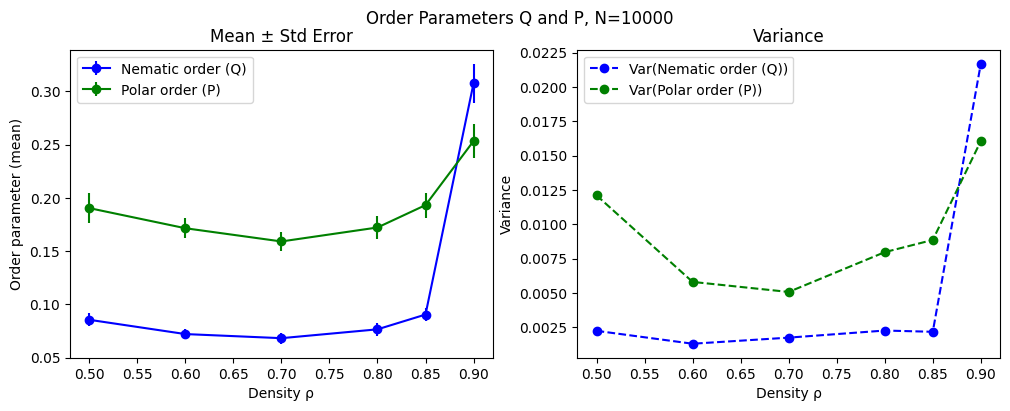

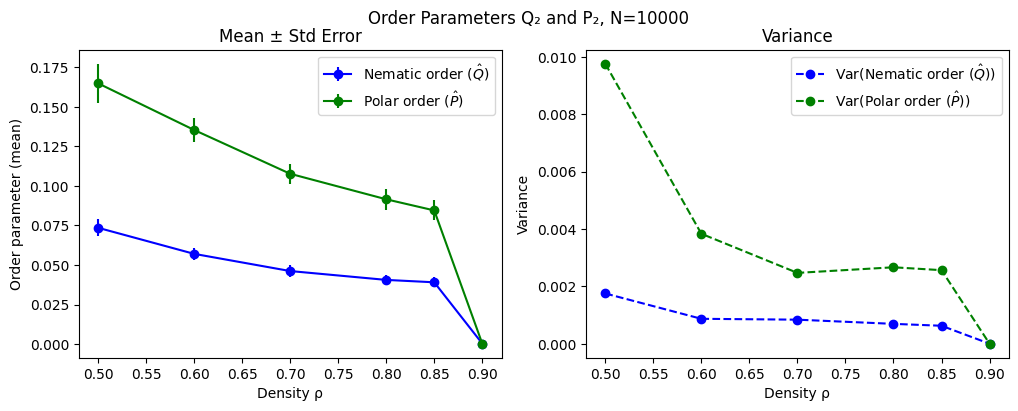

In [9]:
number_of_cells= 10_000
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
# Define DataFrames to save means and stds
df_mean = pd.DataFrame(columns=["density", "nematic_order", "polar_order", "nematic_order_2", "polar_order_2"])
df_std = pd.DataFrame(columns=["density", "nematic_order_std", "polar_order_std", "nematic_order_2_std", "polar_order_2_std"])

# For each density, calculate the order parameters and add the results to the dataframes
for dens in density_list:
    result = calculate_final_order_parameter(number_of_cells, max_step + 1, dens, step, rng_seed)
    mean = result["mean"]
    std = result["std"]

    df_mean.loc[len(df_mean)] = [dens, mean["nematic_order"], mean["polar_order"], mean["nematic_order_2"], mean["polar_order_2"]]
    df_std.loc[len(df_std)] = [dens, std["nematic_order"], std["polar_order"], std["nematic_order_2"], std["polar_order_2"]]

# Caclulate the length of the error bars
error_bars = df_std / np.sqrt(number_of_realizations)

num_cells_folder = f"N={number_of_cells:_}"
folder_path = f"graphs/{num_cells_folder}/order_parameters/op_steady_state"
os.makedirs(folder_path, exist_ok=True)

plot_mean_and_variance_steady_states(
    df_mean=df_mean,
    df_std=df_std,
    error_bars=error_bars,
    var_names=["nematic_order", "polar_order"],
    labels=["Nematic order (Q)", "Polar order (P)"],
    output_path=f"graphs/{num_cells_folder}/order_parameters/op_steady_state/op_steady_state_N={number_of_cells}.png",
    title=f"Order Parameters Q and P, N={number_of_cells}"
)

plot_mean_and_variance_steady_states(
    df_mean=df_mean,
    df_std=df_std,
    error_bars=error_bars,
    var_names=["nematic_order_2", "polar_order_2"],
    labels=[r"Nematic order ($\hat{Q}$)", r"Polar order ($\hat{P}$)"],
    output_path=f"graphs/{num_cells_folder}/order_parameters/op_steady_state/op_2_steady_state_N={number_of_cells}.png",
    title=f"Order Parameters Q₂ and P₂, N={number_of_cells}"
)
